# Latent Dirichlet Allocation (LDA)

This notebook attempts to use LDA to model the topics in a group of Bugzilla bugs through text analysis.

Also want to use [this approach](https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/) to use grid search to determine the most meaningful number of topics that exist in the text.

In [2]:
%run LoadData.ipynb

C:\Users\n71583\AppData\Local\Continuum\anaconda3\lib\site-packages\urllib3\contrib\pyopenssl.py:46: DeprecationWarning: OpenSSL.rand is deprecated - you should use os.urandom instead
  import OpenSSL.SSL


Loaded 2000 bugs
Created DataFrame named df
['id', 'title', 'component', 'product', 'text', 'reporter', 'commenters']


In [3]:
#Global Imports
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Now let's take a look at the content of the bugs that we retrieved.

First we can check the distribution of bugs across the defined components:

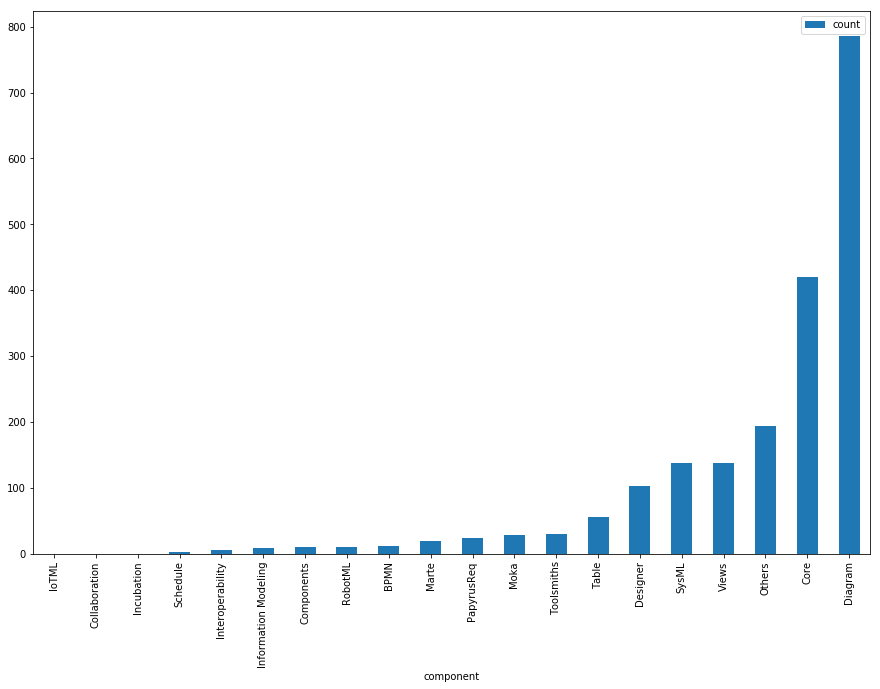

In [4]:
grouped = df.loc[:,['id','component']].groupby('component').count()
grouped.columns = ['count']
grouped.sort_values(by='count').plot(kind='bar', figsize=(15,10))
plt.show()

# Cleaning Data

If you have ever worked with software bugs, you know that many of them are lacking enough information to be useful. On the other hand, some will take on a life of their own and change direction over time.

In this analysis, we will try to remove the bugs that have little text as well as those that have an overwhelming length of text.

We start by showing the distribution of the length, followed by calculation of the 3*sigma cuttof points. Seeing that this method will not work for this non-normal distribution, we use the Interquartile Range (IQR) instead.

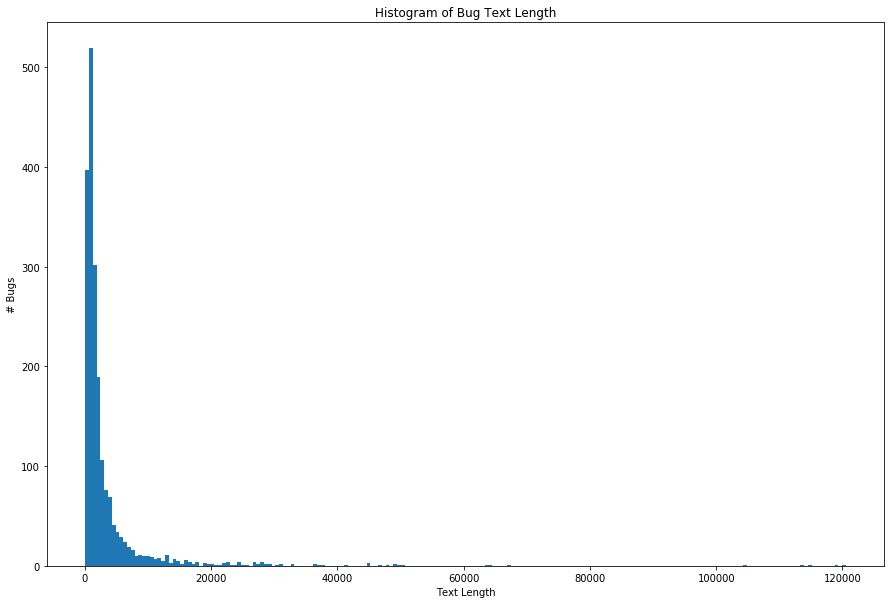

Min/Max length of any bug is 34/120563

Mean of text length is 3532
 
Standard Deviation of the text length is 8250

3 Sigma cuttoff values are lower: -21218 and upper: 28283

Interquartile Range is 2215

IQR cuttoff values are lower: -2585 and upper: 6275



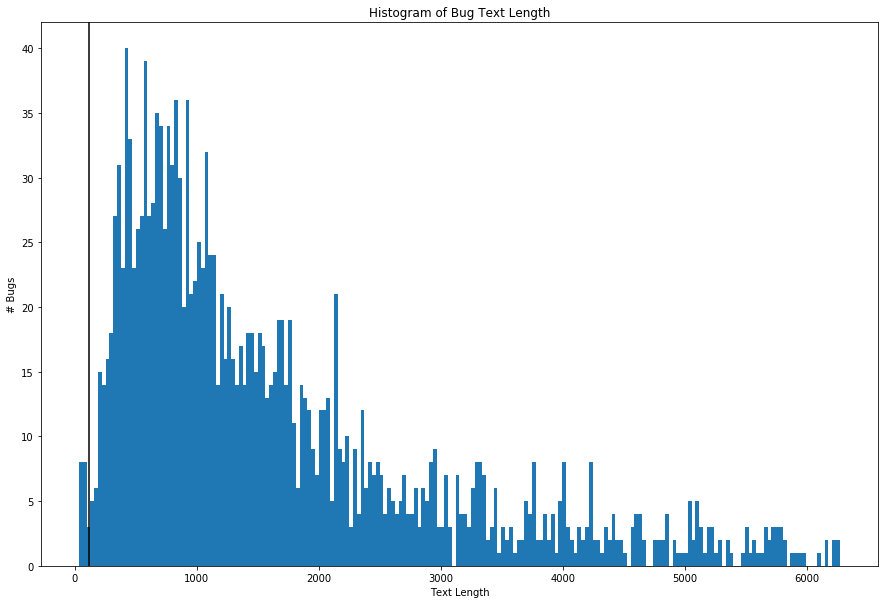

Using a manually defined lower value of 120 (See Vertical Black Line Above)

The resulting set contains 1750 bugs



In [5]:
df['length'] = df['text'].str.len()
text_arr = df.loc[:,'length'].values

# Plot a histogram of the text length
plt.figure(figsize=(15,10))
plt.xlabel('Text Length')
plt.ylabel('# Bugs')
plt.title('Histogram of Bug Text Length')
plt.hist(text_arr, bins=200)
plt.show()

print('Min/Max length of any bug is %d/%d\n'%(np.min(text_arr), np.max(text_arr)))

# Find the values bounding the 98 percentile
# May want to filter these later
mean = np.mean(text_arr)
print('Mean of text length is %d\n ' % mean)
stdev = np.std(text_arr)
print('Standard Deviation of the text length is %d\n' % stdev)
#Compute 3sigma
sigma = 3*stdev
lower = mean - sigma
upper = mean + sigma

print('3 Sigma cuttoff values are lower: %d and upper: %d\n' % (lower, upper))

q25, q75 = np.percentile(text_arr, 25), np.percentile(text_arr, 75)
iqr = q75 - q25
print('Interquartile Range is %d\n' % iqr)

cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off

print('IQR cuttoff values are lower: %d and upper: %d\n' % (lower, upper))

trimmedDF = df.loc[(df['length'] > lower) & (df['length'] < upper)]

# Let's get a look at these values
text_arr = trimmedDF.loc[:,'length'].values

# Plot a histogram of the text length
plt.figure(figsize=(15,10))
plt.xlabel('Text Length')
plt.ylabel('# Bugs')
plt.title('Histogram of Bug Text Length')
plt.axvline(x=120, color='k')
plt.hist(text_arr, bins=200)
plt.show()

print("Using a manually defined lower value of 120 (See Vertical Black Line Above)\n")
lower = 120
trimmedDF = df.loc[(df['length'] > lower) & (df['length'] < upper)]
text_arr = trimmedDF.loc[:,'length'].values
print('The resulting set contains %d bugs\n' % len(text_arr))

# Create a Tokenize Method
This method provides a simple list of words from the text. We will go ahead and run this against the bugs that we have loaded to find the total number of tokens.


In [6]:
exception_regex = re.compile(r".+Exception[^\n].*\s+at", re.MULTILINE | re.IGNORECASE)
greater_regex = re.compile(r"^> .*$", re.MULTILINE | re.IGNORECASE)
gerrit_created_regex = re.compile(r"New Gerrit change created: [^\ ]+", re.MULTILINE | re.IGNORECASE)
gerrit_merge_regex = re.compile(r"Gerrit change [^\s]+ was merged to [^\.]+\.", re.MULTILINE | re.IGNORECASE)
gerrit_commit_regex = re.compile(r"Commit: [^\ ]+", re.MULTILINE | re.IGNORECASE)

def tokenize(text):
    text = greater_regex.sub("", text)
    text = exception_regex.sub("", text)
    text = gerrit_created_regex.sub("", text)
    text = gerrit_merge_regex.sub("", text)
    text = gerrit_commit_regex.sub("", text)
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in text.split(' '):
        if re.fullmatch('[a-zA-Z]+', token):
            filtered_tokens.append(token)
    return filtered_tokens

# The following piece will count up all of the words in the vocabulary. Usefull information, but it takes a while.
totalvocab = []
count = 0

for i in trimmedDF.loc[:,'text']:
#     count = count+1
    allwords = tokenize(i)
    totalvocab.extend(allwords)
# #     if count > 20:
#         break
print('Total word count: '+str(len(totalvocab)))
print('Total unique words: '+str(len(set(totalvocab))))

Total word count: 308756
Total unique words: 8073


# Create a CountVectorizer


In [7]:
from sklearn.feature_extraction.text import CountVectorizer
tf_vectorizer = CountVectorizer(max_df=0.5, min_df=10, stop_words='english', tokenizer=tokenize)
# tf_vectorizer = CountVectorizer(min_df=5, stop_words='english', tokenizer=tokenize)
%time tf = tf_vectorizer.fit_transform(trimmedDF.loc[:,'text'])
tf_feature_names = tf_vectorizer.get_feature_names()
# Materialize the sparse data
dense = tf.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Data Sparsicity: ", ((dense > 0).sum()/dense.size)*100, "%")

Wall time: 8.63 s
Data Sparsicity:  2.225488576933664 %


In [8]:
from sklearn.decomposition import LatentDirichletAllocation

# Run LDA
%time lda = LatentDirichletAllocation(n_components=7, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

print("\nLog Likelihood: %d ## Perplexity: %d\n" % ((lda.score(tf)), lda.perplexity(tf)))

# Print the top 5 words in each topic
num_words = 5
print('LDA Topics: ')
for topic_idx, topic in enumerate(lda.components_):
    print ("Topic %d:" % (topic_idx), " ".join([tf_feature_names[i] for i in topic.argsort()[:-num_words - 1:-1]]))



Wall time: 4.23 s

Log Likelihood: -698308 ## Perplexity: 487

LDA Topics: 
Topic 0: activity node action nodes size
Topic 1: model papyrus use bug uml
Topic 2: papyrus message dependency error version
Topic 3: label code text state editor
Topic 4: menu element created model attachment
Topic 5: stereotype property profile create properties
Topic 6: diagram create model created class


In [79]:
from sklearn.model_selection import GridSearchCV

# Define Search Param
search_params = {'n_components': [6, 8, 10], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation(learning_method='online')

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(tf)

GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=1, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_components': [6, 8, 10], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [80]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(tf))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 6}
Best Log Likelihood Score:  -244834.677917
Model Perplexity:  492.123868465


In [10]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer, mds='tsne')
pyLDAvis.display(panel)


C:\Users\n71583\AppData\Local\Continuum\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [56]:
topic_labels = []
for topic_idx, topic in enumerate(lda.components_):
    label_string = "Topic "+str(topic_idx)+ ": "+" ".join([tf_feature_names[i] for i in topic.argsort()[:-1 - 1:-1]])
    topic_labels.append(label_string)
    print(label_string)


Topic 0: property
Topic 1: stereotype
Topic 2: model
Topic 3: code
Topic 4: created
Topic 5: create
Topic 6: papyrus


In [57]:
def getLDATopic(row):
    try:
        tf_text = tf_vectorizer.transform([row['text']])
        doc_topic_dist = np.matrix(lda.transform(tf_text))
        #quick and dirty for now. May need to check for separation of values
        return doc_topic_dist.argmax()
    except:
        print(row)
    return -1.0
            
%time trimmedDF.loc[:,'topic'] = trimmedDF.apply(getLDATopic, axis=1)


Wall time: 30 s


In [61]:
print("Homogeneity: %0.3f" % metrics.homogeneity_score(trimmedDF.loc[:,'component'], trimmedDF.loc[:,'topic']))
print("Completeness: %0.3f" % metrics.completeness_score(trimmedDF.loc[:,'component'], trimmedDF.loc[:,'topic']))
print("V-measure: %0.3f" % metrics.v_measure_score(trimmedDF.loc[:,'component'], trimmedDF.loc[:,'topic']))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(trimmedDF.loc[:,'component'], trimmedDF.loc[:,'topic']))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(tf, trimmedDF.loc[:,'topic'], sample_size=1000))


Homogeneity: 0.113
Completeness: 0.113
V-measure: 0.113
Adjusted Rand-Index: 0.078
Silhouette Coefficient: -0.092


Components per Topic:


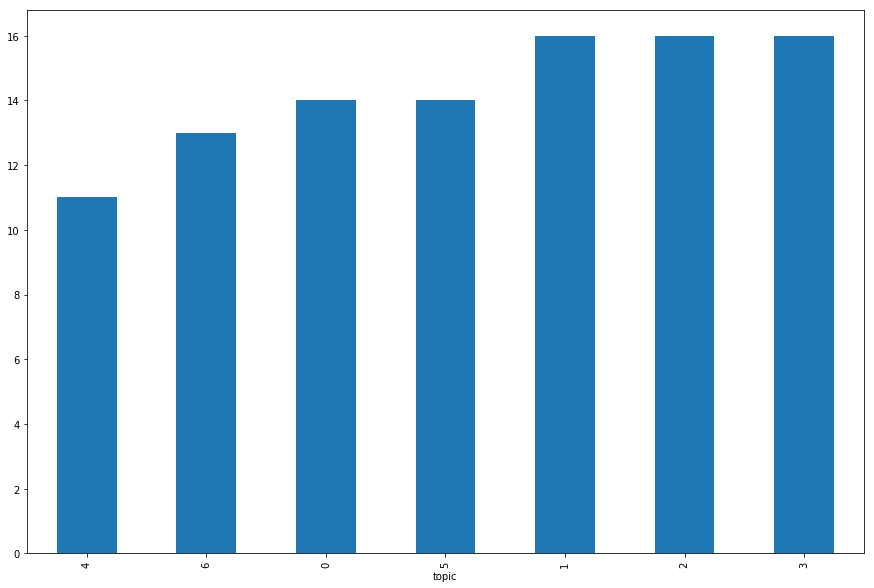

Bugs per Topic:


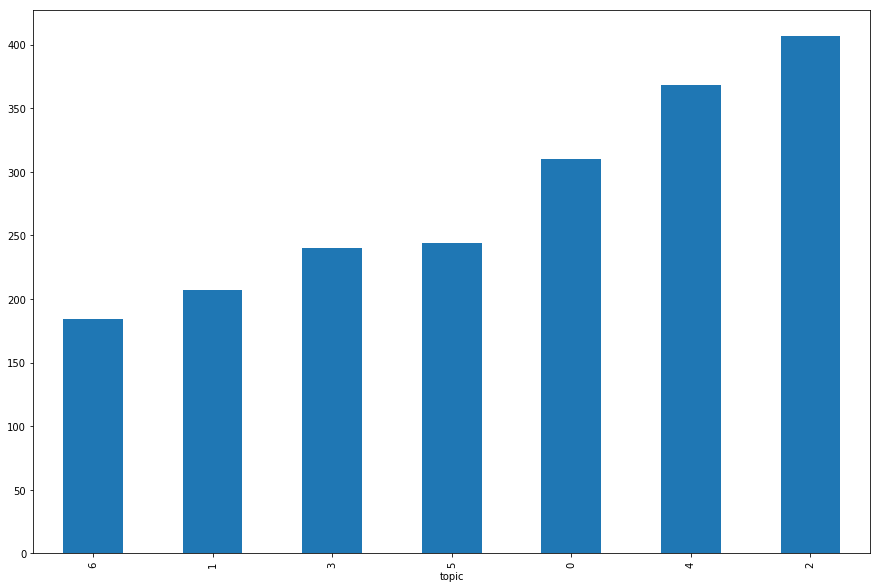

In [58]:
print("Components per Topic:")
grouped = trimmedDF.loc[:,['id','component','topic']].groupby('topic').component.nunique()
grouped.columns = ['count', 'component']
grouped.sort_values().plot(kind='bar', figsize=(15,10))
plt.show()

print("Bugs per Topic:")
grouped = trimmedDF.loc[:,['id','component','topic']].groupby('topic').component.count()
grouped.columns = ['count', 'component']
grouped.sort_values().plot(kind='bar', figsize=(15,10))
plt.show()



# Create a 2D Visualization

Using PCA, create a 2D Visualizaton of the TF/IDF Matrix.

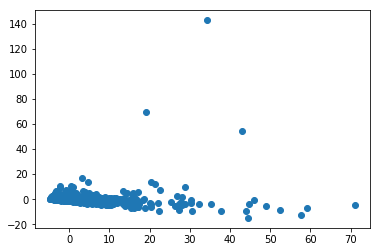

In [59]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

X = tf.todense()

pca = PCA(n_components=2).fit(X)
data2D = pca.transform(X)
plt.scatter(data2D[:,0], data2D[:,1])

plt.show()


C:\Users\n71583\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


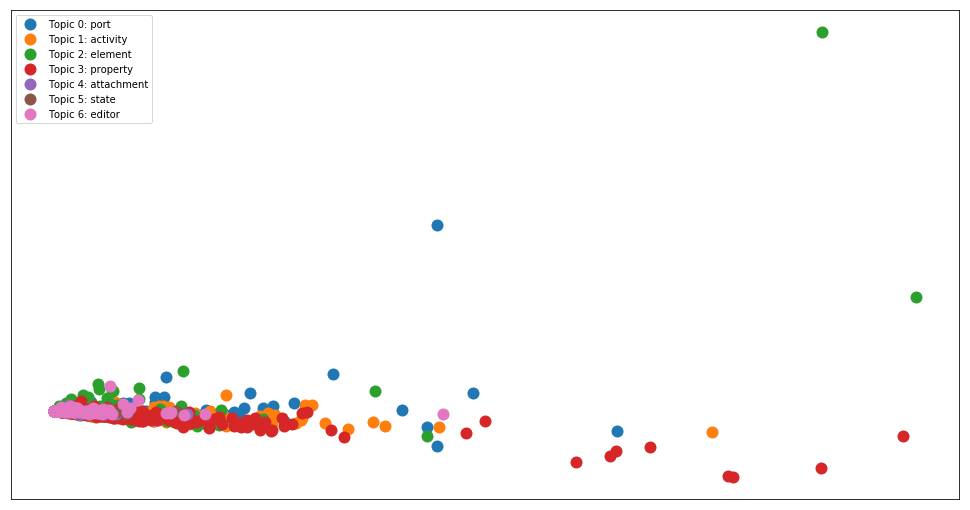

In [41]:
xs, ys = data2D[:, 0], data2D[:, 1]
# df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=trimmedDF.loc[:,'id'])) 
df = pd.DataFrame(dict(x=xs, y=ys, label=trimmedDF.loc[:,'topic'], title=trimmedDF.loc[:,'id'])) 

#group by cluster
groups = df.groupby('label')

# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
#            label=cluster_names[name], color=cluster_colors[name],
#            label=name,
            label=topic_labels[name],
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the bug id
#for i in range(len(df)):
#    ax.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['title'], size=8)  

plt.show() #show the plot


# I'll have another

Now try the same thing with MDS for reducing to 2 dimensions.

Wall time: 5min 42s


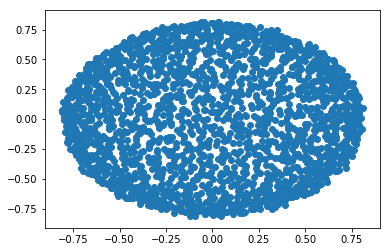

In [14]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tf)

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

%time pos = mds.fit_transform(dist)  # shape (n_components, n_samples)
plt.scatter(pos[:,0], pos[:,1])

plt.show()



C:\Users\n71583\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


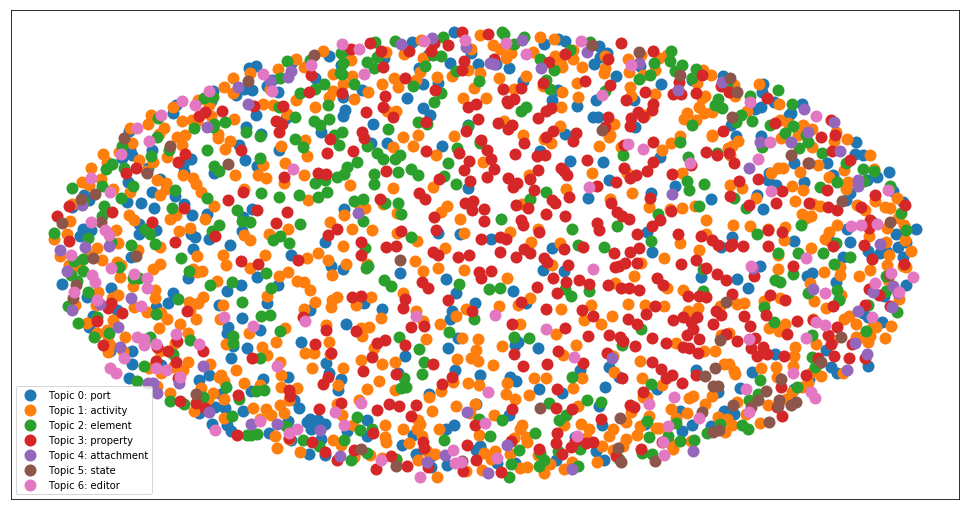

In [43]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
# df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=trimmedDF.loc[:,'id'],)) 
xs, ys = pos[:, 0], pos[:, 1]
df = pd.DataFrame(dict(x=xs, y=ys, label=trimmedDF.loc[:,'topic'], title=trimmedDF.loc[:,'id'],)) 

#group by cluster
groups = df.groupby('label')

# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
#            label=cluster_names[name], color=cluster_colors[name],
#            label=name,
            label=topic_labels[name],
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the bug id
#for i in range(len(df)):
#    ax.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['title'], size=8)  

plt.show() #show the plot


# Create a Verb/Noun Tokenize Method

This method provides another step of filtering to return only words that are nouns or verbs. We will go ahead and run this against the bugs that we have loaded to find the total number of noun/verbs.


In [58]:
import spacy

nlp = spacy.load('en_core_web_sm')
filter = ['VERB', 'NOUN', 'PROPN']
def noun_verb(text):
    filtered_tokens = []
    doc = nlp(text)
    for sent in doc.sents:
        
        # Bugzilla has a tendency to place inline comments in the form of:
        # > Previous Text
        # This will cause a duplicate if not removed.
        if not re.match('^> ', str(sent)):
            for token in sent:
                if token.pos_ in filter and re.fullmatch('[a-zA-Z]+', token.text):
                    filtered_tokens.append(token.text)
    #    else:
    #        print('>Match')
    return filtered_tokens

# The following piece will count up all of the words in the vocabulary. Usefull information, but it takes a while.
totalvocab = []
count = 0
for i in bug_text:
    count = count+1
    allwords = noun_verb(i)
    totalvocab.extend(allwords)
    if count > 20:
        print(count)
        break;
print('Total verb/noun count: '+str(len(totalvocab)))

21
Total verb/noun count: 17325


In [56]:
#Exception
#doc = nlp(bug_text[2])

#Reply
print(bug_ids[19])
print(bug_text[19])
doc = nlp(bug_text[19])
for sent in doc.sents:
    if re.match('^> ', str(sent)):
        print('>Match')
#    print("Sentence->")
#    print(sent)
    if re.match('.+Exception[^\n].*\s+at', str(sent)):
        print('Match!')

508455
Contexts Model Editor error when trying to select datacontext of a view I have a context file open with the Contexts Model Editor.
I select a view.
When I try to set the datacontexts field of the view the editor show numerous errors messages and freeze.

See attachmment.

Thank you. Hi there is no attachment Created attachment 267197
Screenshot Comment on attachment 267197
Screenshot

Arf sorry, here it is. I have a context file open with the Contexts Model Editor.
I select a view.
When I try to set the datacontexts field of the view the editor show numerous errors messages and freeze.

See attachmment.

Thank you. Hi there is no attachment Created attachment 267197
Screenshot Comment on attachment 267197
Screenshot

Arf sorry, here it is.


NameError: name 'nlp' is not defined

In [ ]:
from sklearn.decomposition import TruncatedSVD 
import umap 

# SVD represent documents and terms in vectors 
svd_model = TruncatedSVD(n_components=3, algorithm='randomized', n_iter=100, random_state=122) 
X_topics = svd_model.fit_transform(tf) 
embedding = umap.UMAP(n_neighbors=150, min_dist=0.5, random_state=12).fit_transform(X_topics) 

colors = []
for x,y,z in X_topics:
    colors.append((abs(x), abs(y), abs(z)))
    
plt.figure(figsize=(30,15)) 
i = 0;
for em in embedding:
    plt.scatter(em[0], em[1],
        c = colors[i],
        s = 20, # size 
        edgecolor='none' )
    i = i+1
plt.show()